In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc


In [11]:
# Load dataset
data = pd.read_csv('/content/dataset_extreme.csv')
features = ['feature1', 'feature2', 'feature3']
X = data[features].values
y = data['VPN'].values

# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
# Define custom dataset class
class NaiveBayesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model definition
class NaiveBayesClassifier(nn.Module):
    def __init__(self, num_features):
        super(NaiveBayesClassifier, self).__init__()
        self.linear = nn.Linear(num_features, 2)

    def forward(self, x):
        return torch.softmax(self.linear(x), dim=1)

In [13]:
# Training and validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
learning_rate = 0.01

In [14]:
# Metrics storage
accuracies = []
f1_scores = []
precision_scores = []
recall_scores = []


In [15]:
for train_index, valid_index in skf.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    train_dataset = NaiveBayesDataset(X_train, y_train)
    valid_dataset = NaiveBayesDataset(X_valid, y_valid)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    model = NaiveBayesClassifier(len(features))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # For ROC and PR curves
    y_true = []
    y_scores = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                y_true.extend(targets.numpy().tolist())
                y_scores.extend(outputs[:, 1].numpy().tolist())

    # Calculate metrics
    accuracy = 100 * correct / total
    f1 = f1_score(y_true, np.round(y_scores))
    precision = precision_score(y_true, np.round(y_scores))
    recall = recall_score(y_true, np.round(y_scores))

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)


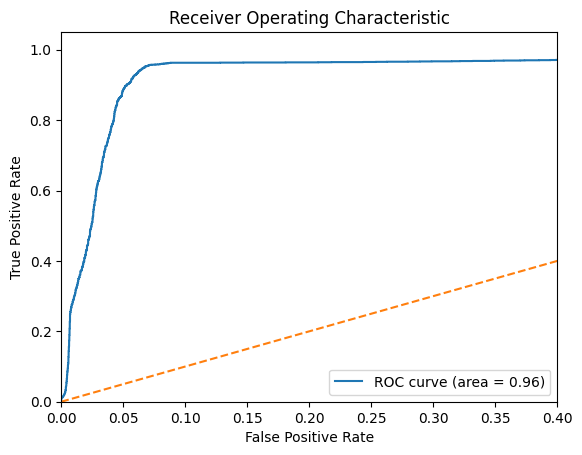

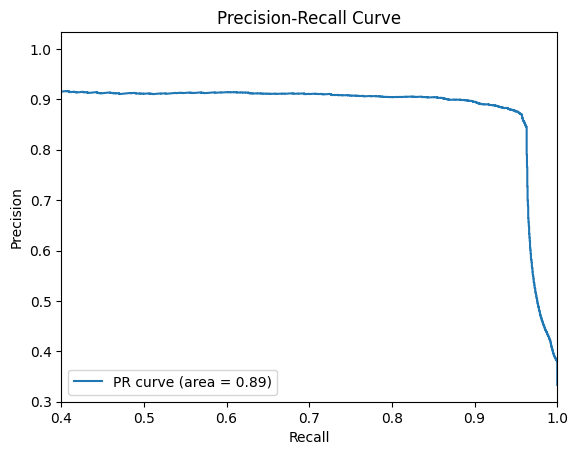

Average Accuracy: 94.32%, Average F-1 score: 90.50%, Average Precision: 88.22%, Average Recall: 92.96%


In [16]:
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.xlim(0, 0.4)
    plt.show()

    # Precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.xlim(0.4, 1)
    plt.show()
    # Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)*100
avg_precision = np.mean(precision_scores)*100
avg_recall = np.mean(recall_scores)*100
print(f'Average Accuracy: {avg_accuracy:.2f}%, Average F-1 score: {avg_f1_score:.2f}%, Average Precision: {avg_precision:.2f}%, Average Recall: {avg_recall:.2f}%')